In [484]:
import requests
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# USE NEW SITES IN NOTES

## Sites
|   |Lat   |Lon   |Ozone   |PM2.5   |NO2   |
|---|---|---|---|---|---|
|LA North Main Street   |34.06653   |-118.22676   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2899&ptype=aqd)	   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=2899&ptype=aqd&monitor=-&std15=aqd)  |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2899&ptype=aqd)   |
|Compton   |33.90145   |-118.20499   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3743&ptype=aqd)|[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=3743&monitor=-&ptype=aqd) [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3743&ptype=aqd)   |
|Reseda   |34.19920   |-118.53275   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2420&ptype=aqd)  |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=2420&monitor=-&ptype=aqd)  [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=2420&ptype=aqd)   |
|Long Beach Signal Hill   |33.79371   |-118.17102   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=OZONE&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3843&ptype=aqd)   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=PM25HR&units=001&year=2020&report=SITE1YR&statistic=DAVG&site=3679&monitor=-&ptype=aqd) [AND](/Users/kevinmarlis/Downloads/ad_viz_plotval_data.csv) (Long Beach (South))   |[data](https://www.arb.ca.gov/aqmis2/display.php?param=NO2&year=2020&units=007&report=SITE1YR&statistic=DMAX&site=3843&ptype=aqd)   |

[EPA Pollution Data](https://www.epa.gov/outdoor-air-quality-data/download-daily-data)

[Weather Data](https://www.ncdc.noaa.gov/cdo-web/)




# Data vars

In [500]:
start_date = '2020-01-01'
end_date = '2020-12-31'
sites = ['LA', 'Compton', 'Reseda', 'LBSH']

data_path = '../AQMD data/Location Data'

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

# Load CARB data

In [501]:
# Get majority of data
data = {}
sites.sort()
for site in sites:
    files = [x for x in os.listdir(data_path) if site in x]
    files.sort()
    site_data = []
    
    for f in files:
        var = f.split('_')[-1][:-4].lower()

        df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)

        df = df[[c for c in df.columns.to_list() if var in c]]
        df = df.dropna()
        col = df.columns.to_list()[0]
        df = df.rename(columns={col: col.split('_')[0]})
        
        df.index = pd.DatetimeIndex(df.index)
        df = df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
         
        site_data.append(df)

    merged_site_data = pd.concat(site_data, axis=1)
    
    data[site] = merged_site_data

# Fill in CARB gaps with EPA data

In [502]:
# Fill in PM2.5 gaps
f = 'EPA_PM25.csv'
var = 'Daily Mean PM2.5 Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Long Beach (South)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda PM2.5 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['pm25'] = np.where(data['Reseda']['pm25'].isnull(), reseda_pm_df, data['Reseda']['pm25'])

# Fill in Compton PM2.5 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['pm25'] = np.where(data['Compton']['pm25'].isnull(), compton_pm_df, data['Compton']['pm25'])

# Fill in LA PM2.5 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 9)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['pm25'] = np.where(data['LA']['pm25'].isnull(), la_pm_df, data['LA']['pm25'])

# Fill in Long Beach PM2.5 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Long Beach (South)') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['pm25'] = np.where(data['LBSH']['pm25'].isnull(), lb_pm_df, data['LBSH']['pm25'])

In [503]:
# Fill in NO2 gaps
f = 'EPA_NO2.csv'
var = 'Daily Max 1-hour NO2 Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Signal Hill (LBSH)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda NO2 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 2)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['no2'] = np.where(data['Reseda']['no2'].isnull(), reseda_pm_df, data['Reseda']['no2'])

# Fill in Compton NO2 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['no2'] = np.where(data['Compton']['no2'].isnull(), compton_pm_df, data['Compton']['no2'])

# Fill in LA NO2 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 3)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['no2'] = np.where(data['LA']['no2'].isnull(), la_pm_df, data['LA']['no2'])

# Fill in Long Beach NO2 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Signal Hill (LBSH)') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['no2'] = np.where(data['LBSH']['no2'].isnull(), lb_pm_df, data['LBSH']['no2'])

In [504]:
# Fill in Ozone gaps
f = 'EPA_OZONE.csv'
var = 'Daily Max 8-hour Ozone Concentration'
aux_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True, index_col=0)
aux_sites = ['Compton', 'Reseda', 'Signal Hill (LBSH)', 'Los Angeles-North Main Street']
aux_df = aux_df[aux_df['Site Name'].isin(aux_sites)]
aux_df = aux_df[['POC', var, 'Site Name']]

# Fill in Reseda NO2 values
reseda_pm_df = aux_df[(aux_df['Site Name'] == 'Reseda') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Reseda']['ozone'] = np.where(data['Reseda']['ozone'].isnull(), reseda_pm_df, data['Reseda']['ozone'])

# Fill in Compton NO2 values
compton_pm_df = aux_df[(aux_df['Site Name'] == 'Compton') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['Compton']['ozone'] = np.where(data['Compton']['ozone'].isnull(), compton_pm_df, data['Compton']['ozone'])

# Fill in LA NO2 values
la_pm_df = aux_df[(aux_df['Site Name'] == 'Los Angeles-North Main Street') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LA']['ozone'] = np.where(data['LA']['ozone'].isnull(), la_pm_df, data['LA']['ozone'])

# Fill in Long Beach NO2 values
lb_pm_df = aux_df[(aux_df['Site Name'] == 'Signal Hill (LBSH)') & (aux_df['POC'] == 1)][var].reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
data['LBSH']['ozone'] = np.where(data['LBSH']['ozone'].isnull(), lb_pm_df, data['LBSH']['ozone'])

# Add climate data

In [505]:
# Compton -> HAWTHORNE MUNICIPAL AIRPORT, CA US
# Reseda -> WOODLAND HILLS PIERCE COLLEGE, CA US
# LA -> LOS ANGELES DOWNTOWN USC, CA US
# LB -> LONG BEACH DAUGHERTY AIRPORT, CA US

f = 'Climate.csv'
climate_df = pd.read_csv(f'{data_path}/{f}', parse_dates=True)

In [506]:
# Compton climate
compton_climate_df = climate_df[climate_df['NAME'] == 'HAWTHORNE MUNICIPAL AIRPORT, CA US']
compton_climate_df.index = pd.DatetimeIndex(compton_climate_df.DATE)
compton_climate_df = compton_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
compton_climate_df = compton_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['Compton'] = pd.concat([data['Compton'], compton_climate_df], axis=1)

# Long Beach climate
lb_climate_df = climate_df[climate_df['NAME'] == 'LONG BEACH DAUGHERTY AIRPORT, CA US']
lb_climate_df.index = pd.DatetimeIndex(lb_climate_df.DATE)
lb_climate_df = lb_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
lb_climate_df = lb_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['LBSH'] = pd.concat([data['LBSH'], lb_climate_df], axis=1)

# Reseda climate
reseda_climate_df = climate_df[climate_df['NAME'] == 'WOODLAND HILLS PIERCE COLLEGE, CA US']
reseda_climate_df.index = pd.DatetimeIndex(reseda_climate_df.DATE)
reseda_climate_df = reseda_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
reseda_climate_df = reseda_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['Reseda'] = pd.concat([data['Reseda'], reseda_climate_df], axis=1)

# LA climate
la_climate_df = climate_df[climate_df['NAME'] == 'LOS ANGELES DOWNTOWN USC, CA US']
la_climate_df.index = pd.DatetimeIndex(la_climate_df.DATE)
la_climate_df = la_climate_df.reindex(pd.date_range(start_date, end_date), fill_value=np.nan)
la_climate_df = la_climate_df[['PRCP', 'AWND', 'TMAX', 'TMIN']]
data['LA'] = pd.concat([data['LA'], la_climate_df], axis=1)

# Interpolate nans and remove outliers

In [519]:
from scipy import stats

for site, df in data.items():
    for col in df.columns:
#         Replace outlier with nan
        print(df[(np.abs(stats.zscore(df[col])) > 3.5)][col])
    
#         Interpolate nans


no2
Series([], Freq: D, Name: no2, dtype: float64)
ozone
2020-09-06    0.152
2020-09-16    0.102
2020-10-04    0.110
Name: ozone, dtype: float64
pm25
Series([], Freq: D, Name: pm25, dtype: float64)
PRCP
Series([], Freq: D, Name: PRCP, dtype: float64)
AWND
2020-11-08    12.75
Freq: D, Name: AWND, dtype: float64
TMAX
2020-09-06    103
Freq: D, Name: TMAX, dtype: int64
TMIN
Series([], Freq: D, Name: TMIN, dtype: int64)
no2
2020-03-21    22.7
2020-03-22    20.6
2020-05-24    18.5
2020-05-25    20.6
2020-05-26    30.8
2020-05-27    25.1
Name: no2, dtype: float64
ozone
Series([], Freq: D, Name: ozone, dtype: float64)
pm25
Series([], Freq: D, Name: pm25, dtype: float64)
PRCP
2020-03-12    1.30
2020-03-22    1.51
2020-04-06    1.10
2020-04-07    0.82
2020-04-09    0.75
2020-12-28    1.81
Name: PRCP, dtype: float64
AWND
2020-02-03    5.82
2020-03-10    4.92
2020-04-09    5.82
2020-12-28    4.70
Name: AWND, dtype: float64
TMAX
2020-09-06    111
Freq: D, Name: TMAX, dtype: int64
TMIN
Series([], F

# Plots

In [478]:
from sklearn import preprocessing
for col in ['TMAX']:
    # Create x, where x the 'scores' column's values as floats
    x = data['LA'][[col]].values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.MinMaxScaler()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)

    # Run the normalizer on the dataframe
    df_normalized = pd.DataFrame(x_scaled)
#     plt.plot(x_scaled)
# data['LA'].columns

In [466]:
l = list(data['LA']['TMIN'])
l.sort()
l

[42,
 42,
 43,
 44,
 44,
 44,
 45,
 46,
 46,
 46,
 46,
 46,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 50,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 52,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 53,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 54,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 55,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 56,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 57,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 58,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 59,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 61,
 61,
 61,
 61,
 61,
 61,
 61,


In [488]:
dfs = [(site, df['TMAX']) for site, df in data.items()]

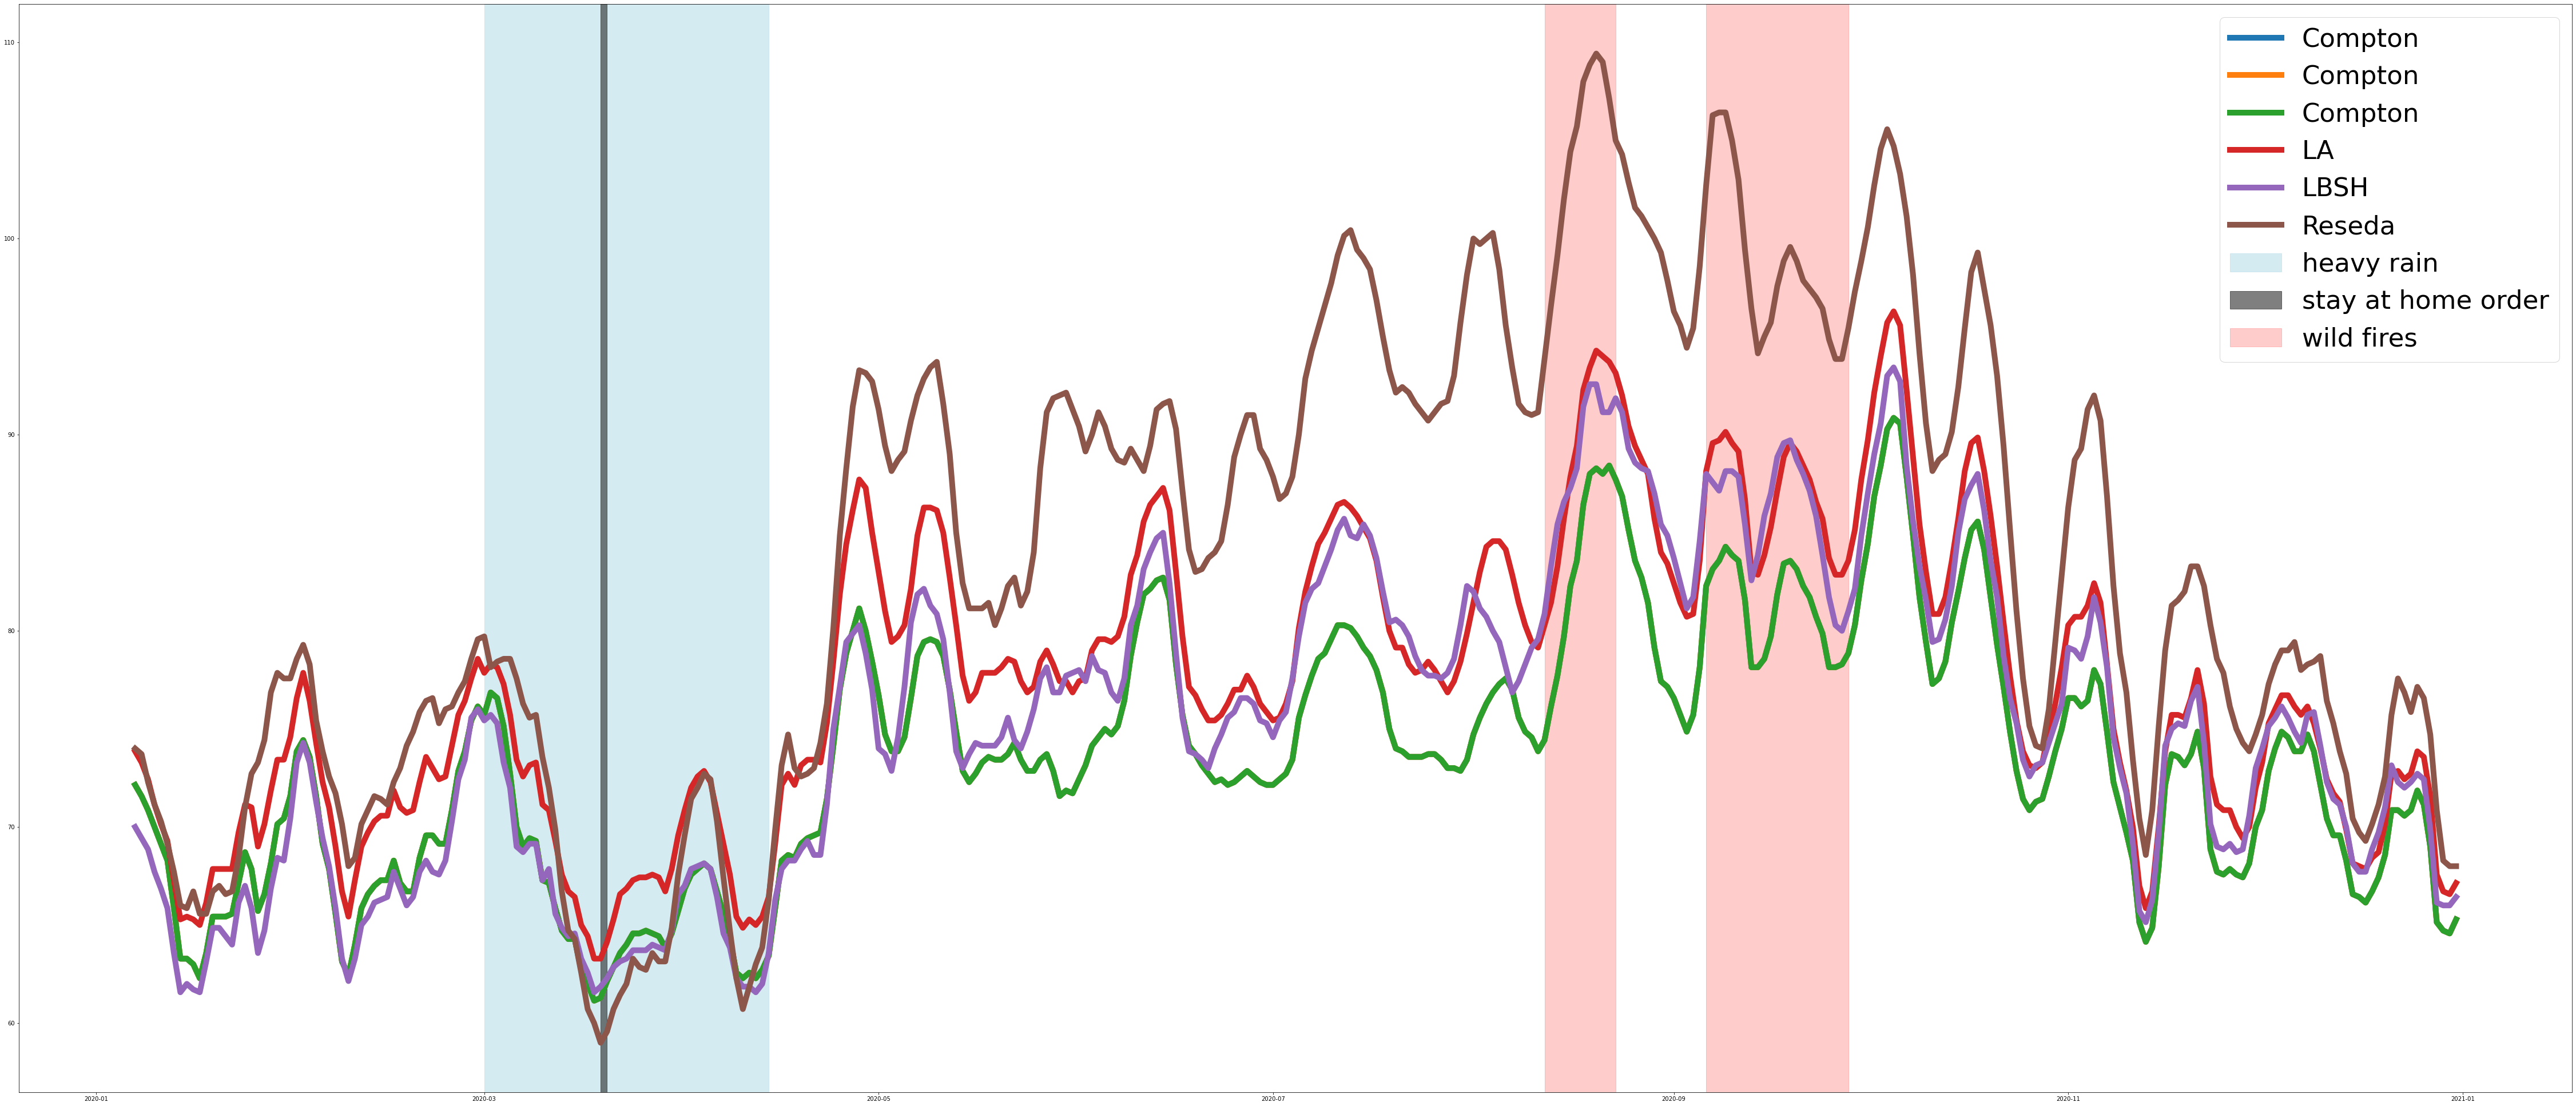

In [489]:
fig = plt.figure(figsize=(80, 35))

for df in dfs:
    plt.plot(df[1].rolling(7).mean(), label=df[0], lw=10)


# ax[i].fill_between(list(range(1, len(x[1])+1)), test[var].rolling(7).mean(),color='mediumseagreen', label='prev decade avg')
# Wet months
plt.axvspan('2020-03-01', '2020-04-14', alpha=0.5, color='lightblue', label='heavy rain')

# Stay at home dates
plt.axvspan('2020-03-19', '2020-03-20', alpha=0.5, color='black', label='stay at home order')

# Fire dates
# http://www.aqmd.gov/home/news-events/news-and-media/2020-news-archives
plt.axvspan('2020-08-12', '2020-08-23', alpha=0.2, color='red', label='wild fires')
plt.axvspan('2020-09-06', '2020-09-28', alpha=0.2, color='red')  

    
plt.legend(prop={'size': 45})
plt.show()
